In [1]:
import numpy as np
import pandas as pd
import matplotlib
print(matplotlib.__version__)
matplotlib.use('PDF')
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.lines as mlines
from glob import glob
from collections import Counter
import re, os
import history_cmc as hic
import math
import scipy
from scipy.interpolate import interp1d
from scipy import stats
import matplotlib.cm as cm
import matplotlib as mpl
import random
from random import shuffle
import gzip
import sys
import astropy as ap
from astropy import units
from scipy.optimize import bisect
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

import dynamics as dyn


sys.path.insert(1, '/projects/b1095/syr904/MyCodes/cmctoolkit')
import cmctoolkit as cmct

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

matplotlib.rcParams.update({'font.size': 22})
rc = {"font.family" : "serif", 
      "mathtext.fontset" : "stix"}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
      
twopi=2.*np.pi
yearsc=3.1557*10**7
Kconst=9.87*10**-48 ##yr/G^2
Gconst=6.674*10**-8 ##cm3*g-1*s-2
Gconst_sun = 4.30091*10**-3 ##pc*M_sun**-1*(km/s)2
clight=3*10**10 ##cm/s
Msun=2*10**33 ##gram
Rsun=6.957e+10 ##cm
AU=1.496*10**13  ##cm
AU_Rsun=214.93946938362 ##AU to R_sun
AU_pc = 4.8481368111358e-6  ##AU to pc
PC=3.086*10**18  ##cm
PC_Rsun = 44334448.0068964 ##pc to R_sun
PC_AU = 206265 ##pc to AU

#savepath = '/projects/b1095/syr904/projects/isolated_MSP/plots/'

2.1.2


# TESTING

In [11]:
##Checking for errors
res_path = '/projects/b1095/syr904/cmc/CMC-COSMIC/wdmerger_update/CMC-COSMIC/CMC/47_load_bin/'
resouts = np.sort(glob(res_path+'resoutput_*.out'))
print(len(resouts))

nerr = 0
ncount=0
binflag_res = []
r_res = []; mtot_res = []; id0_res = []
nline = []
for xx in range(len(resouts)):
    restart_file = resouts[xx]
    nline.append(0)
    with open(restart_file, 'r') as fres:
        next(fres)
        #next(fres)
        for line in fres:
            nline[xx]+=1
            data = line.split()
            #if data[0]=='ix':
            #    continue
            if len(data)!=28:
                nerr+=1
                print('error len', data)
                #print(ncount)
            elif len(data[0].split('.'))!=2:
                nerr+=1
                print('error .', data)
            elif float(data[3])==0:
                nerr+=1
                print('error r=0', data)
            else:
                ncount+=1
                #binflag_res.append(int(data[2]))
                #r_res.append(float(data[3]))
                #mtot_res.append(float(data[6]))
                #id0_res.append(float(data[9]))
                #print(line.rstrip(), file=f)
    print(restart_file, nline[xx])

print(nerr, ncount)
print(np.sum(nline))

112
/projects/b1095/syr904/cmc/CMC-COSMIC/wdmerger_update/CMC-COSMIC/CMC/47_load_bin/resoutput_0.out 17920
/projects/b1095/syr904/cmc/CMC-COSMIC/wdmerger_update/CMC-COSMIC/CMC/47_load_bin/resoutput_1.out 17920
/projects/b1095/syr904/cmc/CMC-COSMIC/wdmerger_update/CMC-COSMIC/CMC/47_load_bin/resoutput_10.out 17920
/projects/b1095/syr904/cmc/CMC-COSMIC/wdmerger_update/CMC-COSMIC/CMC/47_load_bin/resoutput_100.out 17880
/projects/b1095/syr904/cmc/CMC-COSMIC/wdmerger_update/CMC-COSMIC/CMC/47_load_bin/resoutput_101.out 17880
/projects/b1095/syr904/cmc/CMC-COSMIC/wdmerger_update/CMC-COSMIC/CMC/47_load_bin/resoutput_102.out 17880
/projects/b1095/syr904/cmc/CMC-COSMIC/wdmerger_update/CMC-COSMIC/CMC/47_load_bin/resoutput_103.out 17880
/projects/b1095/syr904/cmc/CMC-COSMIC/wdmerger_update/CMC-COSMIC/CMC/47_load_bin/resoutput_104.out 17880
/projects/b1095/syr904/cmc/CMC-COSMIC/wdmerger_update/CMC-COSMIC/CMC/47_load_bin/resoutput_105.out 17880
/projects/b1095/syr904/cmc/CMC-COSMIC/wdmerger_update/CM

In [2]:
##Getting the data
##Snapshot output
#Index(['id', 'm_MSUN', 'r', 'vr', 'vt', 'E', 'J', 'binflag', 'm0_MSUN',
#       'm1_MSUN', 'id0', 'id1', 'a_AU', 'e', 'startype', 'luminosity_LSUN',
#       'radius_RSUN', 'bin_startype0', 'bin_startype1', 'bin_star_lum0_LSUN',
#       'bin_star_lum1_LSUN', 'bin_star_radius0_RSUN', 'bin_star_radius1_RSUN',
#       'bin_Eb', 'eta', 'star_phi', 'rad0', 'rad1', 'tb', 'lum0', 'lum1',
#       'massc0', 'massc1', 'radc0', 'radc1', 'menv0', 'menv1', 'renv0',
#       'renv1', 'tms0', 'tms1', 'dmdt0', 'dmdt1', 'radrol0', 'radrol1',
#       'ospin0', 'ospin1', 'B0', 'B1', 'formation0', 'formation1', 'bacc0',
#       'bacc1', 'tacc0', 'tacc1', 'mass0_0', 'mass0_1', 'epoch0', 'epoch1',
#       'ospin', 'B', 'formation'],
#      dtype='object')

#####Restart file#####
#1.star_r 2.star_m_MSUN 3.bingflag 4.r 5.vr 6.vt 7.m_MSUN 8.m0_MSUN 9.m1_MSUN 
#10.id0 11.id1 12.rad0_RSUN 13.rad1_RSUN 14.mass0_0_MSUN 15.mass0_1_MSUN 16.a_AU 17.ecc 18.m0_zams_MSUN 19.m1_zams_MSUN 
#20.k0 21.k1 22.ospin0_rad/yr 23.ospin1_rad/yr 24.epoch0_Myr 25.epoch1_Myr 26.tphys_Myr 27.mc0_MSUN 28.mc1_MSUN


res_path = '/projects/b1095/syr904/cmc/CMC-COSMIC/wdmerger_update/CMC-COSMIC/CMC/47_load_bin/'
resouts = glob(res_path+'resoutput*.out')
print(len(resouts))

binflag_res = []
r_res = []; mtot_res = []
vr_res = []; vt_res = []
id0_res = []

sma_res = []; ecc_res = []
m0_res = []; m1_res = []
k0_res = []; k1_res = []
mc0_res = []; mc1_res = []
ospin0_res = []; ospin1_res = []
epoch0_res = []; epoch1_res = []
B0_res = []; B1_res = []
m00_res = []; m01_res = []

nline = []
for xx in range(len(resouts)):
    restart_file = res_path+'resoutput_'+str(xx)+'.out'
    nline.append(0)
    with open(restart_file, 'r') as fres:
        next(fres)
        for line in fres:
            nline[xx]+=1
            data = line.split()
            
            binflag_res.append(int(data[2]))
            r_res.append(float(data[3]))
            mtot_res.append(float(data[6]))
            vr_res.append(float(data[4])); vt_res.append(float(data[5]))
            
            id0_res.append(float(data[9]))
            sma_res.append(float(data[15])); ecc_res.append(float(data[16]))
            k0_res.append(int(data[19])); k1_res.append(int(data[20]))
            ospin0_res.append(float(data[21])); ospin1_res.append(float(data[22]))
            epoch0_res.append(float(data[23])); epoch1_res.append(float(data[24]))
            mc0_res.append(float(data[26])); mc1_res.append(float(data[27]))
            m00_res.append(float(data[13])); m01_res.append(float(data[14]))
            


binflag_res = np.array(binflag_res)
r_res = np.array(r_res); mtot_res = np.array(mtot_res)
sma_res = np.array(sma_res); ecc_res = np.array(ecc_res)
k0_res = np.array(k0_res); k1_res = np.array(k1_res)
ospin0_res = np.array(ospin0_res); ospin1_res = np.array(ospin1_res)
epoch0_res = np.array(epoch0_res); epoch1_res = np.array(epoch1_res)
mc0_res = np.array(mc0_res); mc1_res = np.array(mc1_res)
m00_res = np.array(m00_res); m01_res = np.array(m01_res)

#####Snapshot file#####
#original_path = '/projects/b1095/syr904/cmc/CMC-COSMIC/wdmerger_update/CMC-COSMIC_modified/CMC/runs/n8-rv0.5-rg8-z0.0002_ICold/'
original_path = '/projects/b1095/syr904/cmc/CMC-COSMIC/master_tc_test/ver_0601/MOCHA47Tuc_elson_rv4_3e6_tcon/'
l_conv = dyn.conv('l', original_path+'initial.conv.sh')

snap_h5 = cmct.Snapshot(fname=original_path+'initial.snapshots.h5', snapshot_name='/784(t=0.62617053)', 
                     conv=original_path+'initial.conv.sh', 
                     z=0.0038)

binflag = np.array(snap_h5.data['binflag'])
mtot = np.array(snap_h5.data['m_MSUN'])
r = np.array(snap_h5.data['r'])
id0_snap0 = np.array(snap_h5.data['id0'])[binflag == 1]
id1_snap0 = np.array(snap_h5.data['id1'])[binflag == 1]
vr = np.array(snap_h5.data['vr']); vt = np.array(snap_h5.data['vt'])

sma = np.array(snap_h5.data['a_AU']); ecc = np.array(snap_h5.data['e'])
k0 = np.array(snap_h5.data['bin_startype0']); k1 = np.array(snap_h5.data['bin_startype1'])
mc0 = np.array(snap_h5.data['massc0']); mc1 = np.array(snap_h5.data['massc1'])
m00 = np.array(snap_h5.data['mass0_0']); m01 = np.array(snap_h5.data['mass0_1'])
epoch0 = np.array(snap_h5.data['epoch0']); epoch1 = np.array(snap_h5.data['epoch1'])
ospin0 = np.array(snap_h5.data['ospin0']); ospin1 = np.array(snap_h5.data['ospin1'])
ospin = np.array(snap_h5.data['ospin'])

print('nres', np.sum(nline), 'nsnap', len(mtot))
print('nres bin', len(binflag_res[binflag_res==1]), 'nsnap bin', len(binflag[binflag==1]))

112
nres 2008465 nsnap 2004722
nres bin 33652 nsnap bin 33451


True
True
False
False
True
True


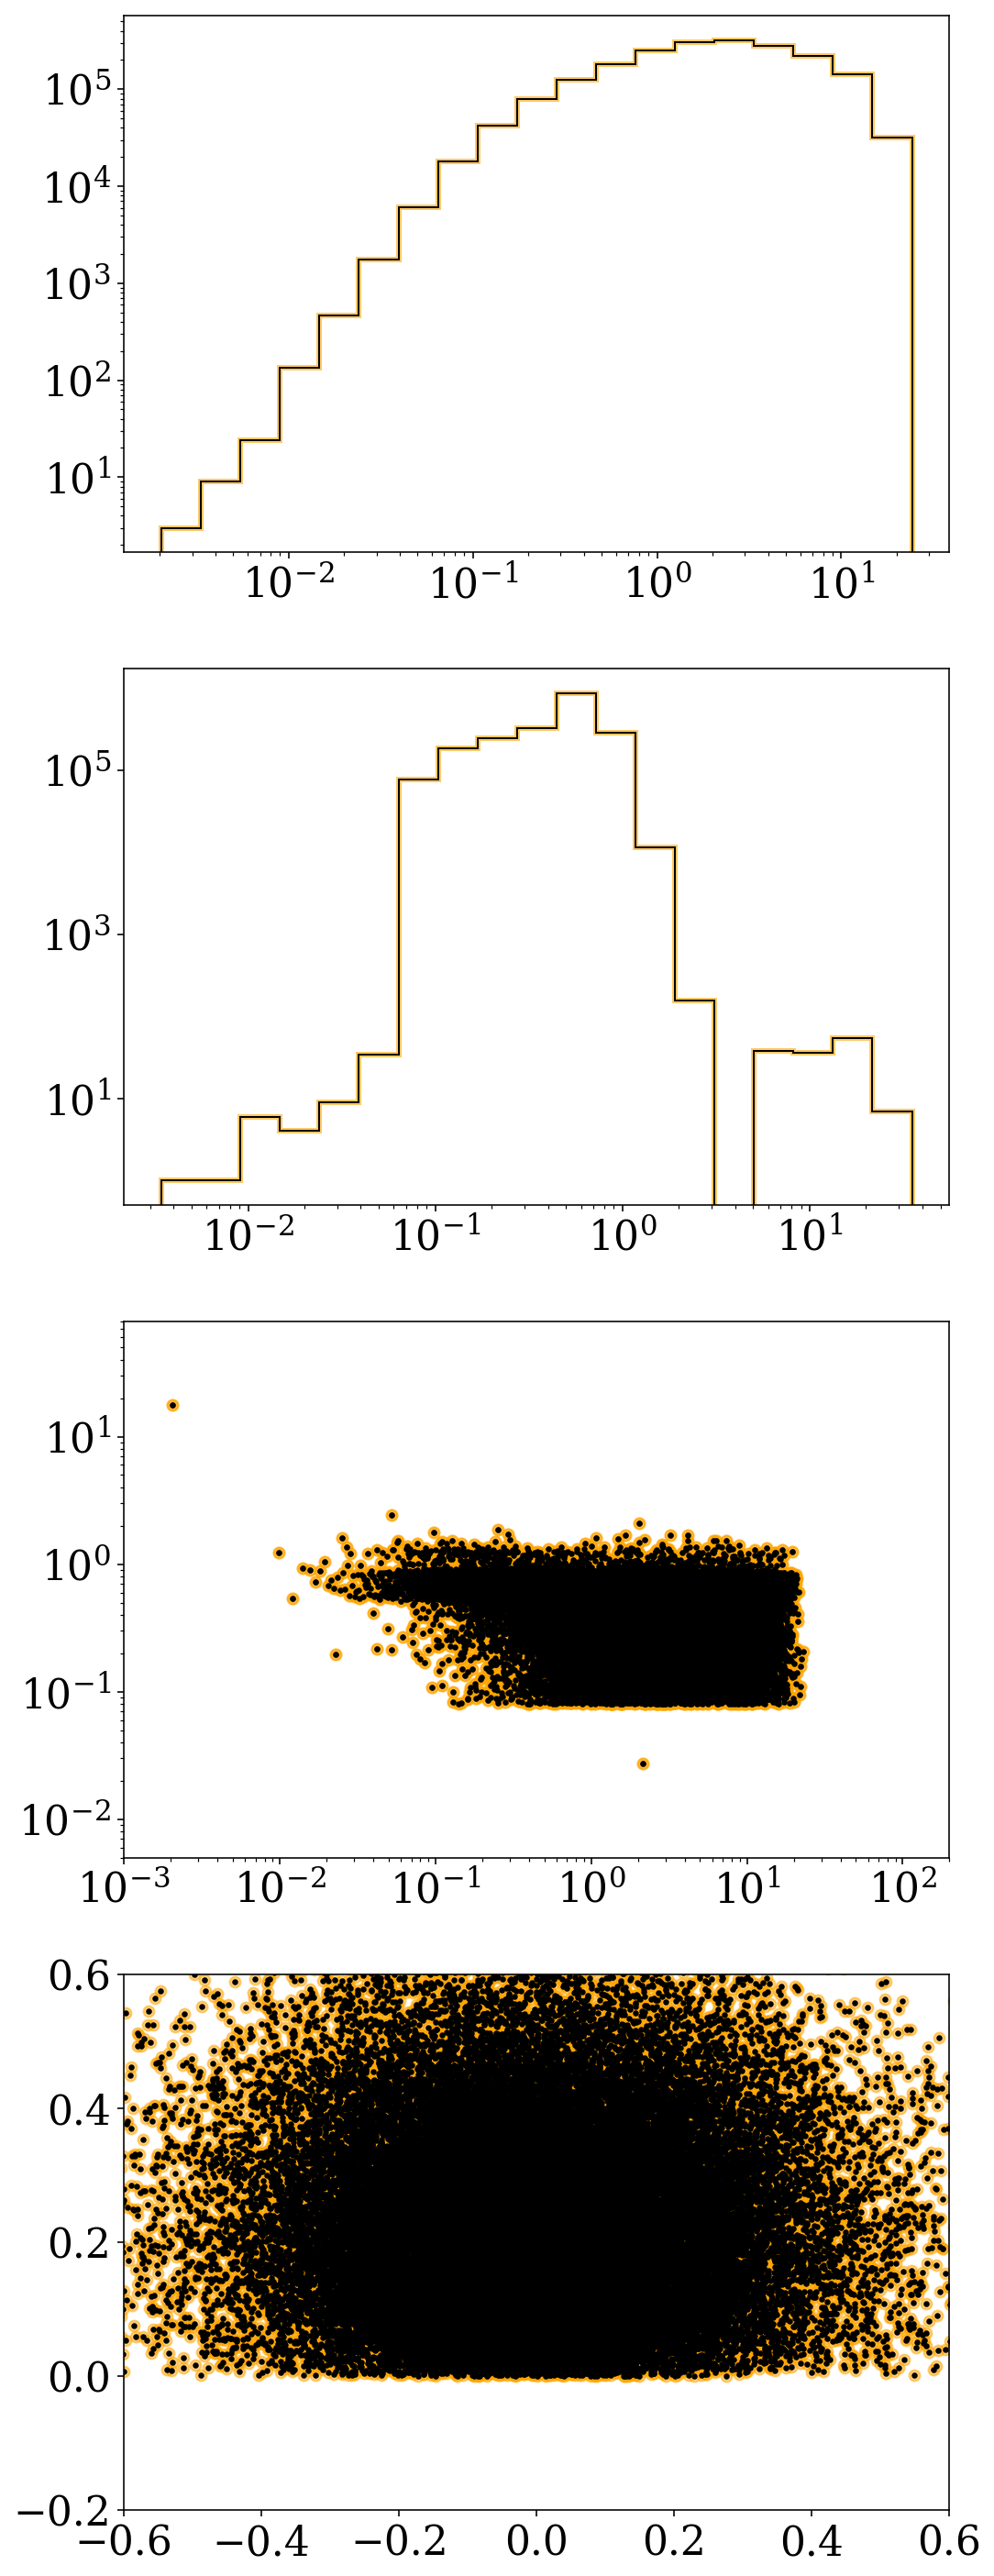

In [14]:
###Comparison
fig, axs = plt.subplots(nrows=4, figsize=(8, 20))
axs[0].hist(r, bins=np.logspace(np.log10(np.min(r)), np.log10(np.max(r)), 20),
            histtype='step', lw=3, alpha=0.6, color='orange')
axs[0].hist(r_res, bins=np.logspace(np.log10(np.min(r_res)), np.log10(np.max(r_res)), 20),
            histtype='step', lw=1, color='k')
axs[0].set_xscale('log')
axs[0].set_yscale('log')

axs[1].hist(mtot, bins=np.logspace(np.log10(np.min(mtot)), np.log10(np.max(mtot)), 20),
            histtype='step', lw=3, alpha=0.6, color='orange')
axs[1].hist(mtot_res, bins=np.logspace(np.log10(np.min(mtot_res)), np.log10(np.max(mtot_res)), 20),
            histtype='step', lw=1, color='k')
axs[1].set_yscale('log')
axs[1].set_xscale('log')

axs[2].scatter(r[::50], mtot[::50], alpha=0.5, color='orange', rasterized=False)
axs[2].scatter(r_res[::50], mtot_res[::50], color='k', s=5, rasterized=False)
axs[2].set_xscale('log')
axs[2].set_yscale('log')
axs[2].set_xlim(xmin=0.001, xmax=200)
axs[2].set_ylim(ymin = 0.005, ymax = 80)

axs[2].scatter(r[::50], mtot[::50], alpha=0.5, color='orange', rasterized=False)
axs[2].scatter(r_res[::50], mtot_res[::50], color='k', s=5, rasterized=False)
axs[2].set_xscale('log')
axs[2].set_yscale('log')
axs[2].set_xlim(xmin=0.001, xmax=200)
axs[2].set_ylim(ymin = 0.005, ymax = 80)

axs[3].scatter(vr[::30], vt[::30], alpha=0.5, color='orange', rasterized=False)
axs[3].scatter(vr_res[::30], vt_res[::30], color='k', s=5, rasterized=False)
#axs[3].set_xscale('symlog')
#axs[3].set_yscale('symlog')
axs[3].set_xlim(xmin=-0.6, xmax=0.6)
axs[3].set_ylim(ymin = -0.2, ymax = 0.6)

fig.tight_layout()

print(np.array_equal(r,r_res))
print(np.array_equal(mtot,mtot_res))
print(np.array_equal(vr,vr_res))
print(np.array_equal(vt, vt_res))
print(np.allclose(vr,vr_res))
print(np.allclose(vt, vt_res))

#print(np.where(vr!=vr_res))
#print(np.where(vt!=vt_res))

#print(vt[1300], vr[4])

True
False
True
True
True
True
True
True
False
True
True
True
True
True


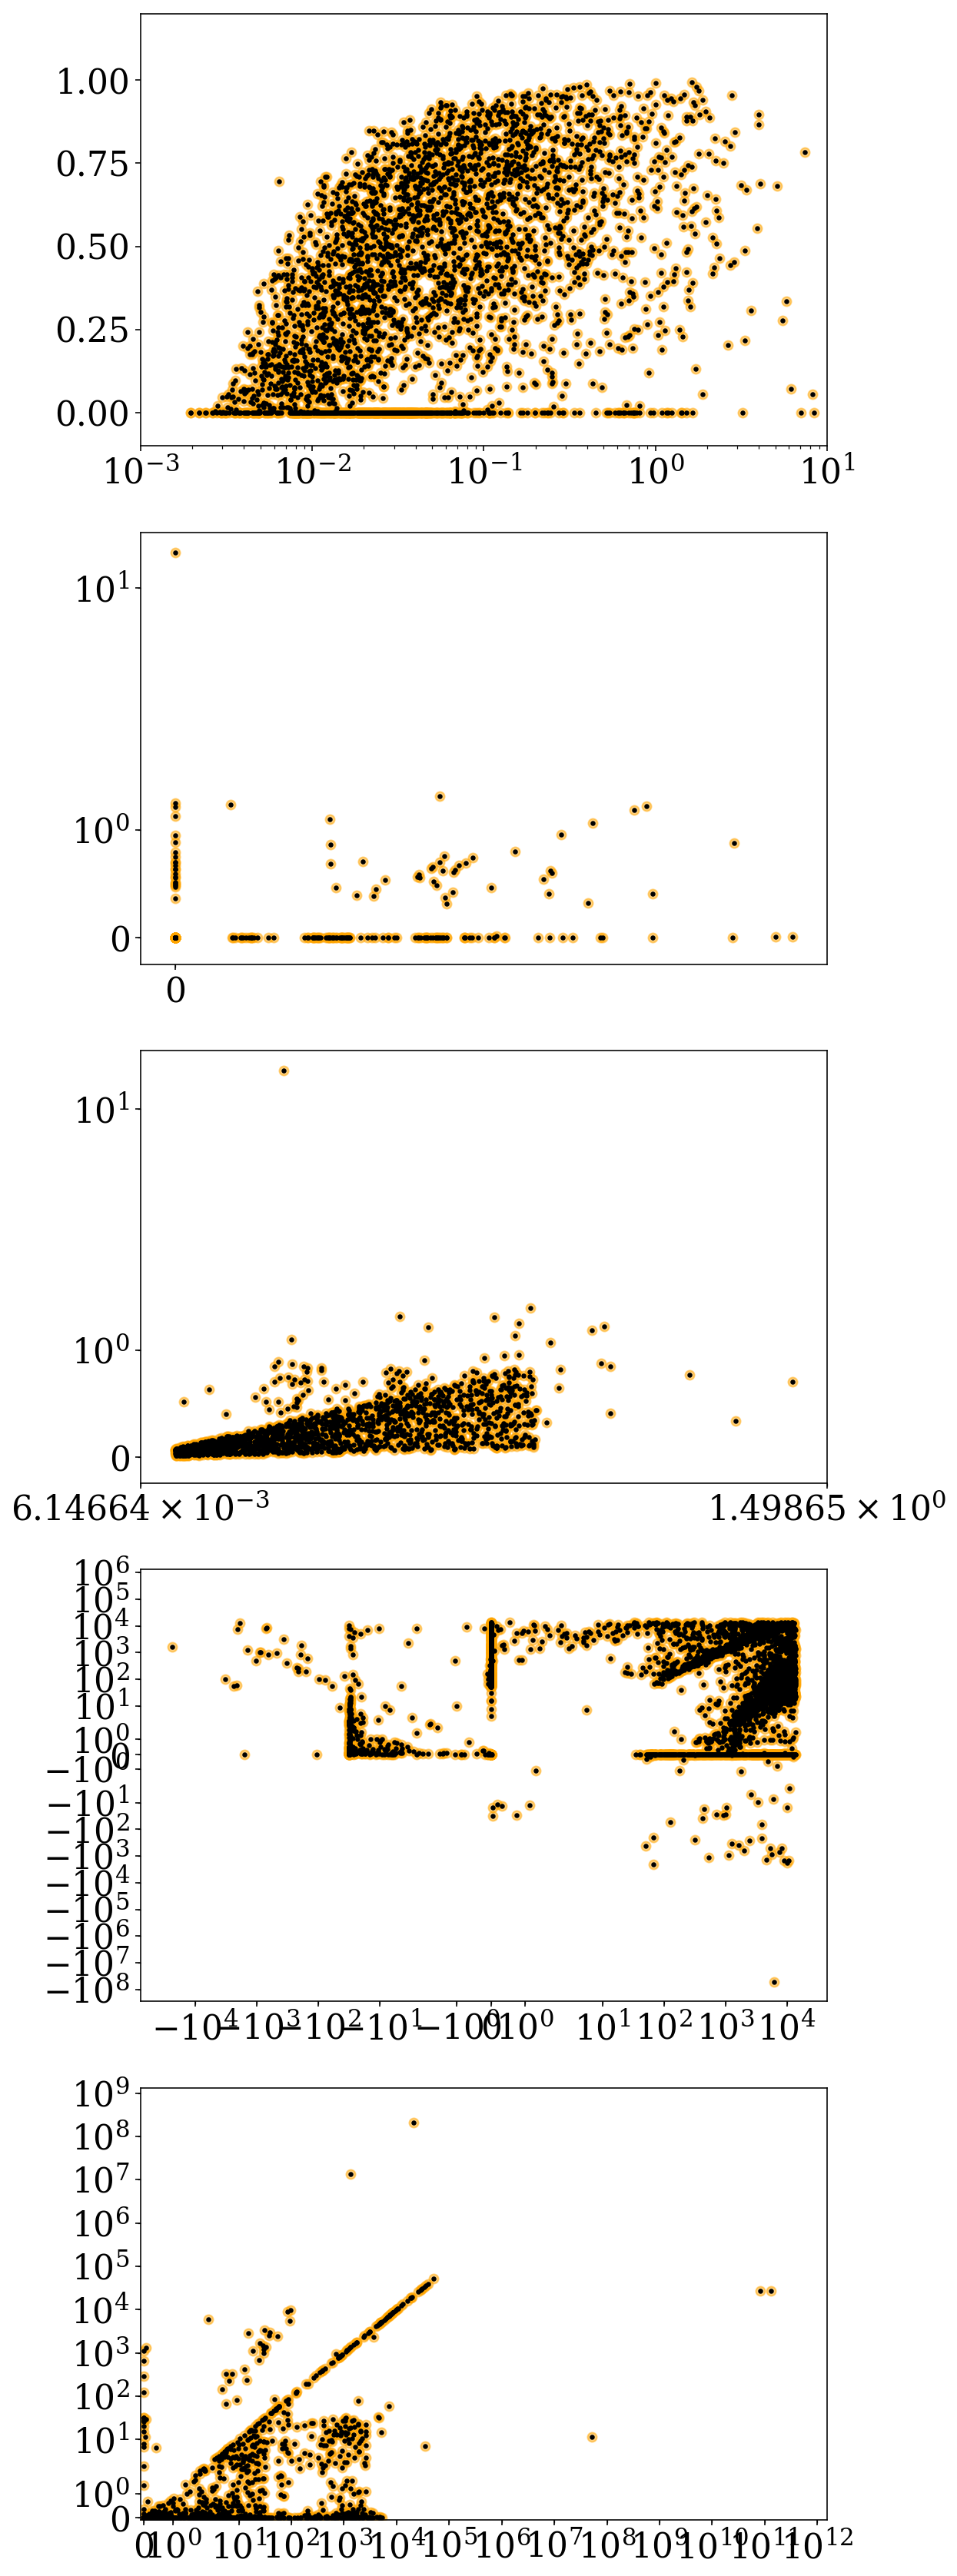

In [15]:
##Comparison binaries
fig, axs = plt.subplots(nrows=5, figsize=(8, 30))
axs[0].scatter(sma[binflag==1][::10], ecc[binflag==1][::10], alpha=0.5, color='orange', rasterized=False)
axs[0].scatter(sma_res[binflag_res==1][::10], ecc_res[binflag_res==1][::10], color='k', s=5, rasterized=False)
axs[0].set_xscale('log')
#axs.set_yscale('log')
axs[0].set_xlim(xmin=0.001, xmax=10)
axs[0].set_ylim(ymin=-0.1, ymax = 1.2)

axs[1].scatter(mc0[binflag==1][::20], mc1[binflag==1][::20], alpha=0.5, color='orange', rasterized=False)
axs[1].scatter(mc0_res[binflag_res==1][::20], mc1_res[binflag_res==1][::20], color='k', s=5, rasterized=False)
axs[1].set_xscale('symlog')
axs[1].set_yscale('symlog')

axs[2].scatter(m00[binflag==1][::20], m01[binflag==1][::20], alpha=0.5, color='orange', rasterized=False)
axs[2].scatter(m00_res[binflag_res==1][::20], m01_res[binflag_res==1][::20], color='k', s=5, rasterized=False)
axs[2].set_xscale('symlog')
axs[2].set_yscale('symlog')

axs[3].scatter(epoch0[binflag==1], epoch1[binflag==1], alpha=0.5, color='orange', rasterized=False)
axs[3].scatter(epoch0_res[binflag_res==1], epoch1_res[binflag_res==1], color='k', s=5, rasterized=False)
axs[3].set_xscale('symlog')
axs[3].set_yscale('symlog')

axs[4].scatter(ospin0[binflag==1][::20], ospin1[binflag==1][::20], 
               alpha=0.5, color='orange', rasterized=False)
axs[4].scatter(ospin0_res[binflag_res==1][::20], ospin1_res[binflag_res==1][::20], 
               color='k', s=5, rasterized=False)
axs[4].set_xscale('symlog')
axs[4].set_yscale('symlog')
axs[4].set_xlim(xmin=-0.1)
axs[4].set_ylim(ymin=-0.1)

print(np.array_equal(sma,sma_res))
print(np.array_equal(ecc,ecc_res))
print(np.array_equal(mc0[binflag==1], mc0_res[binflag==1]))
print(np.array_equal(mc1[binflag==1], mc1_res[binflag==1]))
print(np.array_equal(m00[binflag==1], m00_res[binflag==1]))
print(np.array_equal(m01[binflag==1], m01_res[binflag==1]))
print(np.array_equal(k0[binflag==1], k0_res[binflag_res==1]))
print(np.array_equal(k1[binflag==1], k1_res[binflag_res==1]))
print(np.array_equal([1,2,3,4], [4,3,2,1]))
print(np.allclose(ecc,ecc_res))
print(np.allclose(mc0[binflag==1], mc0_res[binflag==1]))
print(np.allclose(mc1[binflag==1], mc1_res[binflag==1]))
print(np.allclose(m00[binflag==1], m00_res[binflag==1]))
print(np.allclose(m01[binflag==1], m01_res[binflag==1]))

#print(np.where(r!=r_res))
#print(r[0], r_res[0])

#print(sma[binflag==1][1000])
#print(ecc[binflag==1][1000])
#print(mc0[binflag==1][10000])
#print(m00[binflag==1][1000])
#print(epoch0[binflag==1][504])

# Extracting Data

In [3]:
##Convert 1D to 3D
def convert_to_3d(r, vr, vt, SEEDY=10):
    #np.random.seed(SEEDY)
    random.seed(SEEDY)
    #costheta = np.random.uniform(-1, 1)
    #sintheta = (1-costheta**2.)**0.5

    if np.shape(r)==():
        #print 'came here'
        sintheta = np.random.uniform(low=-1., high=1.)
        phi = np.random.uniform(low=0., high=2.*np.pi)
        anglev = np.random.uniform(low=0., high=2.*np.pi)
    else:
        #print 'came here too'
        r = np.array(r)
        vr = np.array(vr)
        vt = np.array(vt)
    
        sintheta = np.random.uniform(low=-1., high=1., size=len(r))
        phi = np.random.uniform(low=0., high=2.*np.pi, size=len(r))
        anglev = np.random.uniform(low=0., high=2.*np.pi, size=len(r))

    print(sintheta, phi, anglev)
        
    costheta = (1-sintheta**2.)**0.5
    #costheta = (1-sintheta**2.)**0.5
    #phi = np.random.uniform(low=0., high=2.*np.pi, size=len(r))
    
    rz = r*sintheta
    rx = r*costheta*np.cos(phi)
    ry = r*costheta*np.sin(phi)
    
    #anglev = np.random.uniform(low=0., high=2.*np.pi, size=len(r))
    magv = (vr*vr + vt*vt)**0.5 
    thetadot = np.cos(anglev) * vt/r
    phidot = np.sin(anglev)*vt/(r*costheta)
    
    #vx = vr * np.sin(np.arccos(costheta)) * np.cos(phi) + r * thetadot * costheta * np.cos(phi) - r * phidot * np.sin(np.arccos(costheta)) * np.sin(phi)
    vx = vr * costheta * np.cos(phi) - r * phidot * costheta * np.sin(phi) - r * thetadot * sintheta * np.cos(phi)
    #vy = vr * np.sin(np.arccos(costheta)) * np.sin(phi) + r * thetadot * costheta * np.sin(phi) + r * phidot * np.sin(np.arccos(costheta)) * np.cos(phi)
    vy = vr * costheta * np.sin(phi) + r * phidot * costheta * np.cos(phi) - r * thetadot * sintheta * np.sin(phi)
    #vz = vr * costheta - r * thetadot * np.sin(np.arccos(costheta))
    vz = vr * sintheta + r * thetadot * costheta


    r3d = np.array([rx, ry, rz])
    v3d = np.array([vx, vy, vz])

    return r3d, v3d

In [4]:
def binary_keplerian_to_cartesian(m1, m2, a, ecc):
    '''Need to sample Keplerian orbital elements
        inclination inc, 0-180 degrees
        longitude of the ascending node omega, 0-360 degrees
        argument of periapsis w, 0-360 degrees
        true anomaly nu, 0-360 degrees
        
        a is in AU and the masses are in solar mass
        
        return X, Y, Z and VX, vy, vz w.r.t. the central body and the meaning of i, ω and Ω to its reference frame.
        in units of pc and km/s
        
    '''
    
    list_inc = np.random.uniform(low=0., high=np.pi, size=len(a))
    list_nu = np.random.uniform(low=0., high=twopi, size=len(a))
    list_omega = np.random.uniform(low=0., high=twopi, size=len(a))
    list_w = np.random.uniform(low=0, high=twopi, size=len(a))
    
    ###testing only###
    #n=50
    #list_inc = np.empty(n); list_inc.fill(0.)
    #list_omega = np.empty(n); list_omega.fill(0)
    #list_nu = np.random.uniform(low=0., high=twopi, size=n)
    #list_w = np.empty(n); list_w.fill(0.)#np.repeat(np.linspace(0., twopi, 20), 500)#
    ######
    
    '''Obtain the position and velocity vector o(t) and o'(t), respectively, 
    in the orbital frame (z-axis perpendicular to
    orbital plane, x-axis pointing to periapsis of the orbit)'''
    
    mu = Gconst_sun*(m1+m2)   ###standard gravitational parameter
    
    a = a*AU_pc
    p = a*(1-ecc**2)  ##pc
    d = p / (1 + ecc * np.cos(list_nu))  #pc
    
    x = d * np.cos(list_nu) ##pc
    y = d * np.sin(list_nu) ##pc
    
    h = np.sqrt(mu*p) 
    vn = mu/h   ##km/s
    vx = -vn*np.sin(list_nu)   ##km/s
    vy = vn*(ecc + np.cos(list_nu))   ##km/s
    
    
    '''Generate the rotation matrix'''
    R = np.empty((3, 3, list_inc.size), dtype=np.float64)
    #print(R)
    
    c1 = np.cos(list_omega)
    s1 = np.sin(list_omega)

    c2 = np.cos(list_inc)
    s2 = np.sin(list_inc)

    c3 = np.cos(list_w)
    s3 = np.sin(list_w)

    # col 0
    R[0, 0, ...] = c1*c3 - c2*s1*s3
    R[1, 0, ...] = c3*s1 + c1*c2*s3
    R[2, 0, ...] = s2*s3

    # col 1
    R[0, 1, ...] = -c1*s3 - c2*c3*s1
    R[1, 1, ...] = c1*c2*c3 - s1*s3
    R[2, 1, ...] = c3*s2

    # col 2
    R[0, 2, ...] = s1*s2
    R[1, 2, ...] = -c1*s2
    R[2, 2, ...] = c2
    
    
    X = R[0, 0, ...]*x + R[0, 1, ...]*y    ##pc
    Y = R[1, 0, ...]*x + R[1, 1, ...]*y    ##pc
    Z = R[2, 0, ...]*x + R[2, 1, ...]*y    ##pc
    
    VX = R[0, 0, ...]*vx + R[0, 1, ...]*vy   ##km/s
    VY = R[1, 0, ...]*vx + R[1, 1, ...]*vy   ##km/s
    VZ = R[2, 0, ...]*vx + R[2, 1, ...]*vy   ##km/s
    
    br3d = np.array([X, Y, Z])
    bv3d = np.array([VX, VY, VZ])
    
    return br3d, bv3d

In [5]:
def binary_coordinates_com(r_clus, v_clus, r_cart, v_cart, m1, m2):  ##r_clus, v_clus, r_cart, v_cart are all arrays
    '''Converting to barycentric frame'''
    mtot = m1+m2
    
    r1 = (m2/mtot)*r_cart*(-1.)
    r2 = (m1/mtot)*r_cart
    
    v1 = (m2/mtot)*v_cart*(-1.)
    v2 = (m1/mtot)*v_cart
    
    '''Positions and velocities in the cluster'''
    pos_1 = r_clus + r1
    pos_2 = r_clus + r2
    
    vel_1 = v_clus + v1
    vel_2 = v_clus + v2
    
    return pos_1, pos_2, vel_1, vel_2

<IPython.core.display.Javascript object>


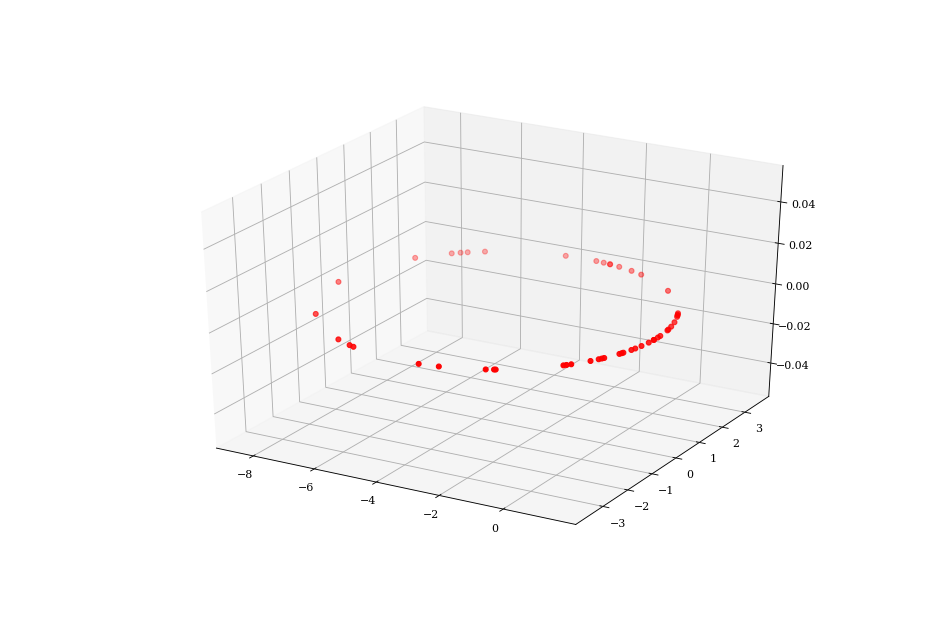

<IPython.core.display.Javascript object>


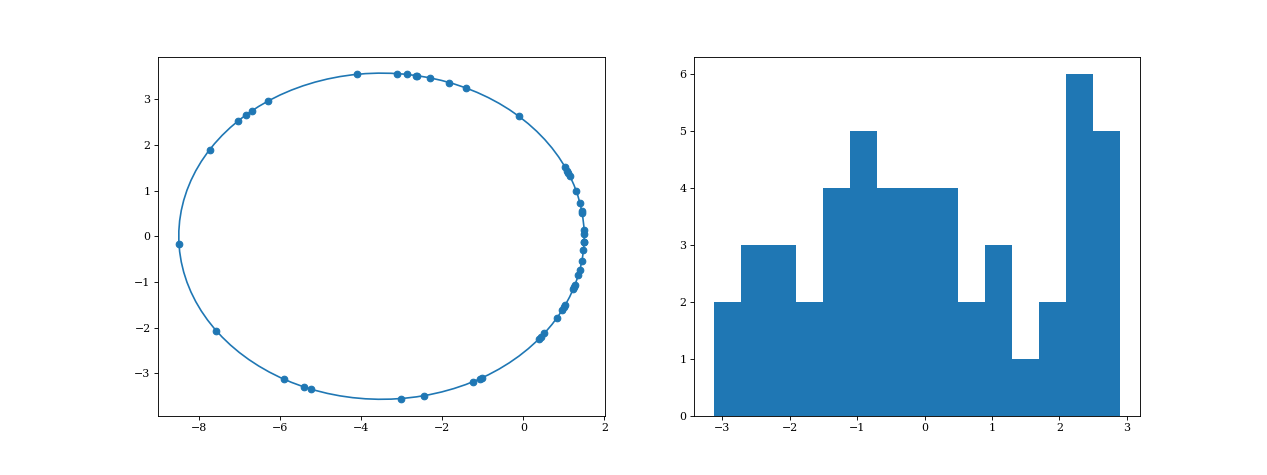

(array([2., 3., 3., 2., 4., 5., 4., 4., 4., 2., 3., 1., 2., 6., 5.]),
 array([-3.12032187, -2.71890496, -2.31748805, -1.91607114, -1.51465423,
        -1.11323732, -0.71182041, -0.31040351,  0.0910134 ,  0.49243031,
         0.89384722,  1.29526413,  1.69668104,  2.09809795,  2.49951486,
         2.90093176]),
 <a list of 15 Patch objects>)

In [40]:
##testing binary component positions
from mpl_toolkits import mplot3d
%matplotlib notebook

sma = 5; ecc = 0.7
smb = sma*math.sqrt(1-ecc**2)
t = np.linspace(0, 2*np.pi, 100)
u=-3.5; v=0

cart_data = binary_component_r_v(2, 2, sma, ecc)
#print(cart_data)

fig = plt.figure(figsize=(12, 8))
ax = plt.axes(projection='3d')
ax.scatter3D(cart_data[0], cart_data[1], cart_data[2], color='red')
xx, yy = np.meshgrid(np.linspace(np.min(cart_data[0])*1.2, np.max(cart_data[0])*2., 10), 
                     np.linspace(np.min(cart_data[1])*1.2, np.max(cart_data[1])*2., 10))
zz = np.zeros_like(xx)
#ax.plot_surface(xx, yy, zz, alpha=0.4, color='gold')

fig, axs = plt.subplots(ncols=2, figsize=(16,6))
axs[0].scatter(cart_data[0], cart_data[1])
axs[0].plot(u+sma*np.cos(t) , v+smb*np.sin(t) )
axs[1].hist(np.arctan2(cart_data[1], cart_data[0]), bins=15)

In [6]:
###Writing to Nbody file###
res_path = '/projects/b1095/syr904/cmc/CMC-COSMIC/wdmerger_update/CMC-COSMIC/CMC/47_load_bin/'
resouts = glob(res_path+'resoutput*.out')
print(len(resouts))


binflag = []
r = []; vr = []; vt = []

mtot= []
m0 = []; m1 = []
mc0 = []; mc1 = []
m00 = []; m01 = []

id0 = []

sma = []; ecc = []
k0 = []; k1 = []
ospin0 = []; ospin1 = []
epoch0 = []; epoch1 = []

nline = []

for xx in range(len(resouts)):
    restart_file = res_path+'resoutput_'+str(xx)+'.out'
    nline.append(0)
    with open(restart_file, 'r') as fres:
        next(fres)
        for line in fres:
            nline[xx]+=1
            data = line.split()
            
            binflag.append(int(data[2]))
            r.append(float(data[3]))
            vr.append(float(data[4])); vt.append(float(data[5]))
            
            mtot.append(float(data[6]))
            m0.append(float(data[7])); m1.append(float(data[8]))
            m00.append(float(data[13])); m01.append(float(data[14]))
            mc0.append(float(data[26])); mc1.append(float(data[27]))
            
            id0.append(float(data[9]))
            
            sma.append(float(data[15])); ecc.append(float(data[16]))
            k0.append(int(data[19])); k1.append(int(data[20]))
            ospin0.append(float(data[21])); ospin1.append(float(data[22]))
            epoch0.append(float(data[23])); epoch1.append(float(data[24]))
            
            
t_conv = dyn.conv('t', res_path+'initial.conv.sh')
l_conv = dyn.conv('l', res_path+'initial.conv.sh')
lengthunitcgs=1.23428e+19
nbtimeunitcgs=2.38988e+12

            
binflag = np.array(binflag)
r_pc = np.array(r)*l_conv
vr_kms = np.array(vr)*lengthunitcgs/nbtimeunitcgs*1e-5; vt_kms = np.array(vt)*lengthunitcgs/nbtimeunitcgs*1e-5
sma = np.array(sma); ecc = np.array(ecc)

m0 = np.array(m0); m1 = np.array(m1)
mtot = np.array(mtot)
m00 = np.array(m00); m01 = np.array(m01)
mc0 = np.array(mc0); mc1 = np.array(mc1)

k0 = np.array(k0); k1 = np.array(k1)
ospin0 = np.array(ospin0); ospin1 = np.array(ospin1)
epoch0 = np.array(epoch0); epoch1 = np.array(epoch1)

R3d_bin, V3d_bin = convert_to_3d(r_pc[binflag==1], vr_kms[binflag==1], vt_kms[binflag==1], SEEDY=10)
R3d_sin, V3d_sin = convert_to_3d(r_pc[binflag!=1], vr_kms[binflag!=1], vt_kms[binflag!=1], SEEDY=10)
print(R3d_bin, len(R3d_bin), len(R3d_bin[0]))

cart_r, cart_v = binary_keplerian_to_cartesian(m0[binflag==1], m1[binflag==1], sma[binflag==1], ecc[binflag==1])

Rb1, Rb2, Vb1, Vb2 = binary_coordinates_com(R3d_bin, V3d_bin, cart_r, cart_v, m0[binflag==1], m1[binflag==1])
print(Rb1, len(Rb1), len(Rb1[0]))

#####Write to files#####

m0_bin = m0[binflag==1]; m1_bin = m1[binflag==1]
m_sin = mtot[binflag!=1]
k0_bin = k0[binflag==1]; k1_bin = k1[binflag==1]
k_sin = k0[binflag!=1]
m00_bin = m00[binflag==1]; m01_bin = m01[binflag==1]
m0_sin = m00[binflag!=1]
mc0_bin = mc0[binflag==1]; mc1_bin = mc1[binflag==1]
mc_sin = mc0[binflag!=1]

epoch0_bin = epoch0[binflag==1]; epoch1_bin = epoch1[binflag==1]
epoch_sin = epoch0[binflag!=1]
ospin0_bin = ospin0[binflag==1]; ospin1_bin = ospin1[binflag==1]
ospin_sin = ospin0[binflag!=1]

print(len(m0_bin), len(m_sin))

#f1 = open('/projects/b1095/syr904/cmc/CMC-COSMIC/wdmerger_update/CMC-COSMIC/CMC/47_load_bin/file1_pos_vel.dat', 'w+')
#f1.write('#1.M[Msun] 2.X[pc] 3.Y[pc] 4.Z[pc] 5.VX[km/s] 6.VY[km/s] 7.VZ[km/s]\n')
#for xx in range(len(m0_bin)):
#    f1.write('%f %.12f %.12f %.12f %f %f %f\n'
#             %(m0_bin[xx], Rb1[0][xx], Rb1[1][xx], Rb1[2][xx], Vb1[0][xx], Vb1[1][xx], Vb1[2][xx]))
#    f1.write('%f %.12f %.12f %.12f %f %f %f\n'
#             %(m1_bin[xx], Rb2[0][xx], Rb2[1][xx], Rb2[2][xx], Vb2[0][xx], Vb2[1][xx], Vb2[2][xx]))
#
#for yy in range(len(m_sin)):
#    f1.write('%f %.12f %.12f %.12f %f %f %f\n'
#             %(m_sin[yy], R3d_sin[0][yy], R3d_sin[1][yy], R3d_sin[2][yy], 
#               V3d_sin[0][yy], V3d_sin[1][yy], V3d_sin[2][yy]))
#    
#f1.close()
#print('file1 done')
#
#f2 = open('/projects/b1095/syr904/cmc/CMC-COSMIC/wdmerger_update/CMC-COSMIC/CMC/47_load_bin/file2_stars.dat', 'w+')
#f2.write('#1.M1[Msun] 2.KW 3.M0[Msun] 4.EPOCH1[Myr] 5.OSPIN[rad/yr] 6.MC[Msun]\n')
#for xx in range(len(m0_bin)):
#    f2.write('%f %d %f %f %e %f\n'
#             %(m0_bin[xx], k0_bin[xx], m00_bin[xx], epoch0_bin[xx], ospin0_bin[xx],
#              mc0_bin[xx]))
#    f2.write('%f %d %f %f %e %f\n'
#             %(m1_bin[xx], k1_bin[xx], m01_bin[xx], epoch1_bin[xx], ospin1_bin[xx],
#              mc1_bin[xx]))
#
#for yy in range(len(m_sin)):
#    f2.write('%f %d %f %f %e %f\n'
#             %(m_sin[yy], k_sin[yy], m0_sin[yy], epoch_sin[yy], ospin_sin[yy],
#              mc_sin[yy]))
#    
#f2.close()
#
#print('file2 done')

np.savetxt('/projects/b1095/syr904/cmc/CMC-COSMIC/wdmerger_update/CMC-COSMIC/CMC/47_load_bin/file3_pos_vel_m0m1_sma_ecc.dat',
           np.c_[m0[binflag==1], m1[binflag==1], sma[binflag==1], ecc[binflag==1], 
                 R3d_bin[0], R3d_bin[1], R3d_bin[2], 
                 V3d_bin[0], V3d_bin[1], V3d_bin[2]],
           header = '1.M0[Msun] 2.M1[Msun] 3.SMA[AU] 4.ECC 5.X[pc] 6.Y[pc] 7.Z[pc] 8.VX[km/s] 9.VY[km/s] 10.VZ[km/s]',
           comments = '#')
print('file3 done')

112
[ 0.28807668 -0.66866477 -0.71805155 ... -0.00682476 -0.21628539
 -0.64995565] [4.56139144 3.59165616 1.84745145 ... 2.8045996  5.62720084 4.5442488 ] [3.93696634 4.01444112 4.30671324 ... 3.87072468 2.95090602 5.12074586]
[-0.78145569 -0.09145349 -0.82134534 ... -0.796575   -0.60072048
 -0.65787578] [0.37553437 1.62220418 4.39490669 ... 3.10685672 3.73196498 2.53281557] [2.8143972  2.53310321 5.64955983 ... 1.98924705 0.31420176 4.52596599]
[[-9.07897794e-04 -1.20752063e-02 -3.51869007e-03 ... -8.39151810e+01
   7.00354784e+01 -1.19029859e+01]
 [-5.96689955e-03 -5.83393540e-03  1.23925320e-02 ...  2.94002929e+01
  -5.39056515e+01 -7.01236523e+01]
 [ 1.81567996e-03 -1.20597905e-02 -1.32907407e-02 ... -6.06847635e-01
  -1.95784312e+01 -6.08301271e+01]] 3 33652
[[-9.07900330e-04 -1.20752079e-02 -3.51872535e-03 ... -8.39151811e+01
   7.00354785e+01 -1.19029859e+01]
 [-5.96690235e-03 -5.83393631e-03  1.23927089e-02 ...  2.94002928e+01
  -5.39056515e+01 -7.01236524e+01]
 [ 1.81568144e-0

# Checking binding energy

In [4]:
###Checking the binding energy of binaries
res_path = '/projects/b1095/syr904/cmc/CMC-COSMIC/wdmerger_update/CMC-COSMIC/CMC/47_load_bin/'
resouts = glob(res_path+'resoutput*.out')
print(len(resouts))


binflag = []

mtot= []
m0 = []; m1 = []

sma = []; ecc = []

nline = []

for xx in range(len(resouts)):
    restart_file = res_path+'resoutput_'+str(xx)+'.out'
    nline.append(0)
    with open(restart_file, 'r') as fres:
        next(fres)
        for line in fres:
            nline[xx]+=1
            data = line.split()
            
            binflag.append(int(data[2]))
            
            mtot.append(float(data[6]))
            m0.append(float(data[7])); m1.append(float(data[8]))
            
            sma.append(float(data[15])); ecc.append(float(data[16]))

            
binflag = np.array(binflag)
sma = np.array(sma); ecc = np.array(ecc)

m0 = np.array(m0); m1 = np.array(m1)
mtot = np.array(mtot)

112


[    1     2     3 ... 33650 33651 33652]
[2.23978838e+05 8.68585728e+03 1.05970953e+05 ... 2.84997797e+02
 3.16742317e+02 3.54357469e+01]
887.1272011499999


Text(0,0.5,'$a\\,{\\rm [AU]}$')

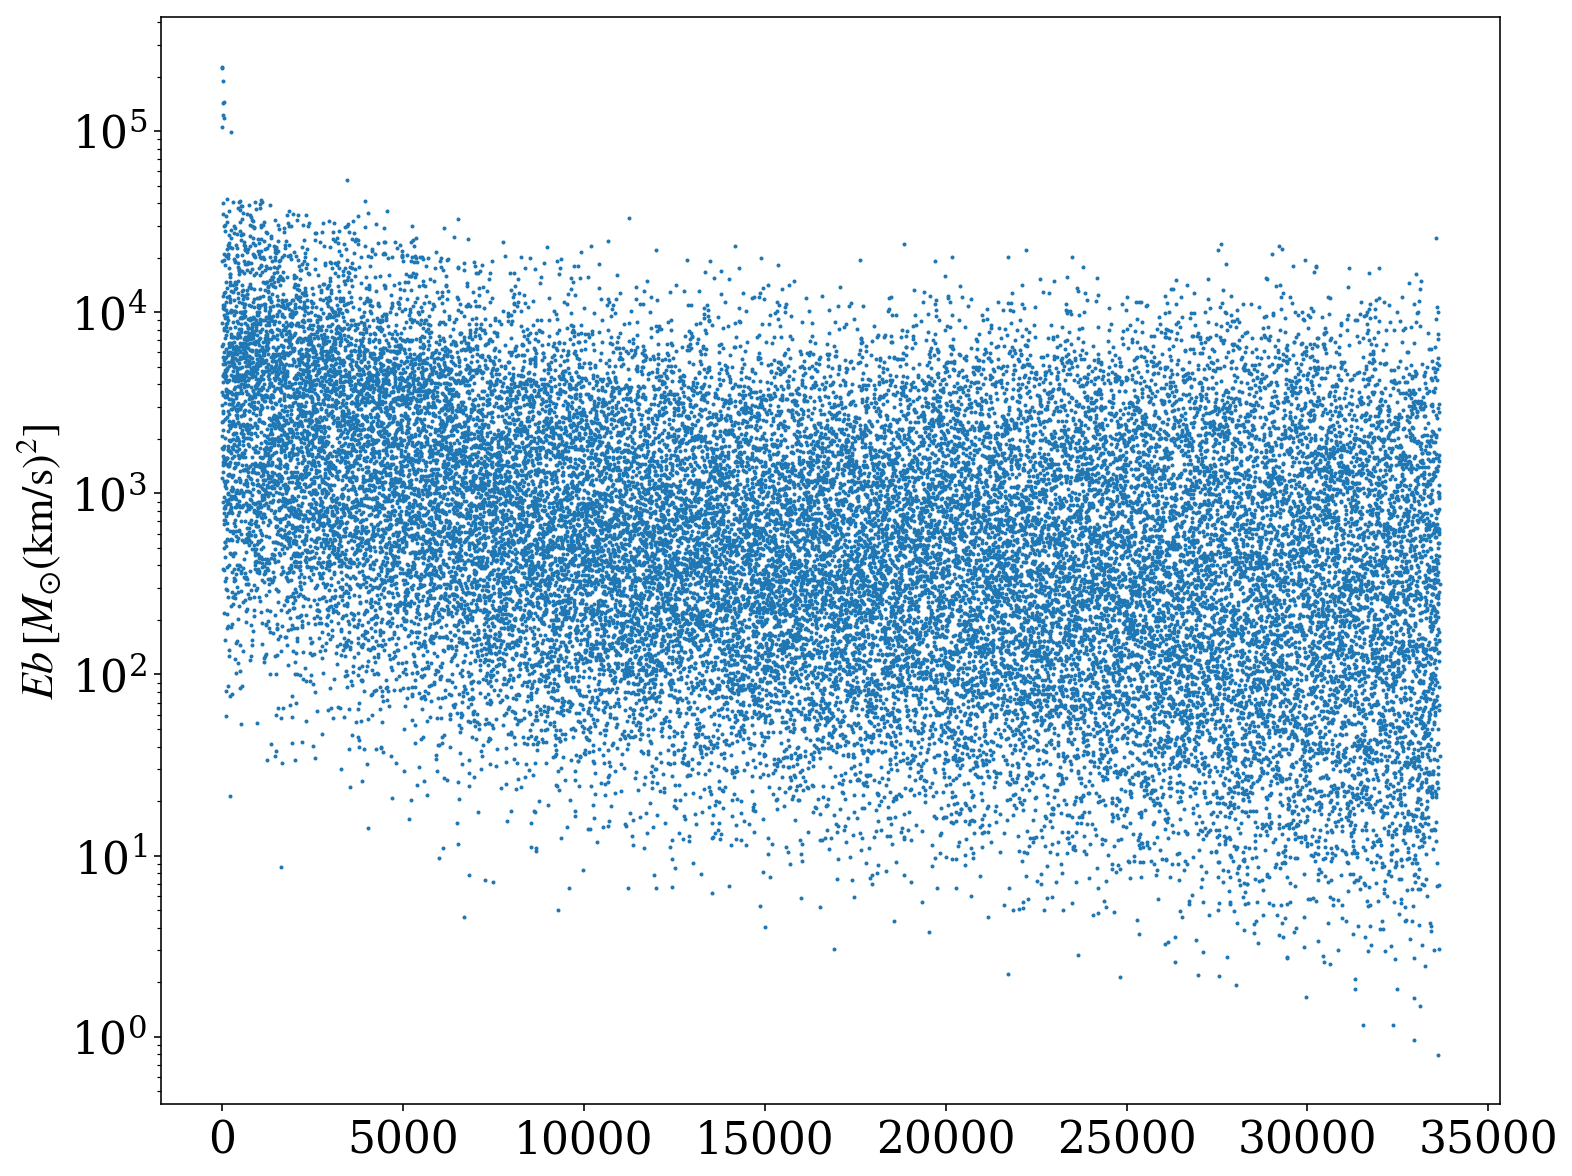

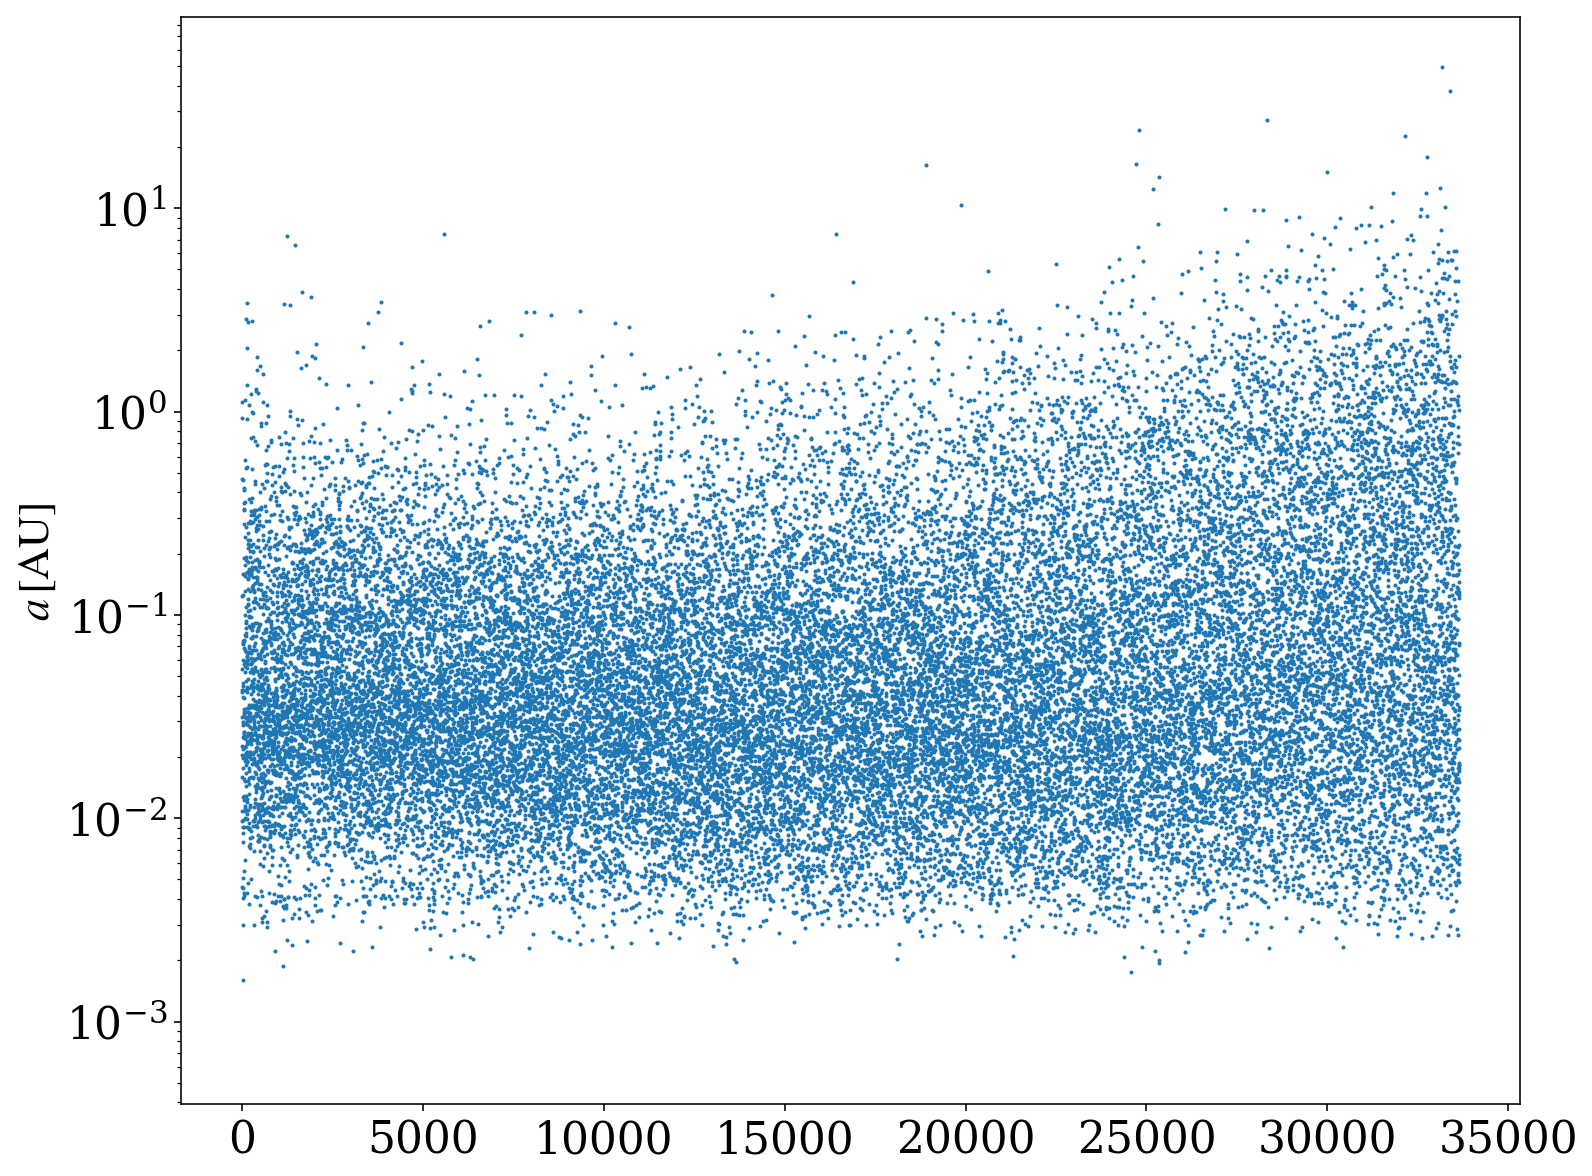

In [10]:
#####Bindng enerrgy#####
m0_bin = m0[binflag==1]; m1_bin = m1[binflag==1]
sma_bin = sma[binflag==1]; ecc_bin = ecc[binflag==1]

Eb = (Gconst_sun*PC_AU)*m0_bin*m1_bin/2./sma_bin
Eb_x = np.arange(len(Eb))+1
print(Eb_x)
print(Eb)
print(Gconst_sun*PC_AU)

plt.figure(figsize=(12,10))
plt.scatter(Eb_x, Eb, s=1)
plt.ylabel(r'$Eb \, [M_{\odot} (\rm km/s)^2]$')
plt.yscale('log')

plt.figure(figsize=(12,10))
plt.scatter(np.arange(len(sma_bin))+1, sma_bin, s=1)
plt.yscale('log')
plt.ylabel(r'$a\,{\rm [AU]}$')
#plt.ylabel(r'$Ecc$')